<a href="https://colab.research.google.com/github/popoloni/covid19/blob/master/covid_19_prediction_for_Italy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Using a mathematical epidemic model, this notebook will predict the number of cases infected with COVID-19 (Novel Corona Virus 2019, 2019-nCOV, SARS-COV-2 virus caused disease).

This study is based on the work of [Lisphilar](https://www.kaggle.com/lisphilar) in his notebook [COVID-19 data with SIR model](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model). Please have a look to this work for the complete and updated work.

In this notebook we mainly focus on a Scenario analysis in Italy
using ["Protezione civile" dataset](https://github.com/pcm-dpc/COVID-19).
 
Note: "Infected" means the currently infected cases. This can be calculated  as "Confirmed" - "Deaths" - "Recovered"
 
Python functions to use repeatedly in this notebook are in "Arrangement of dataset > Functions"

In [0]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'19Mar2020 13:38'

# Arrangement of dataset

In [0]:
!pip install optuna

     |████████████████████████████████| 153kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 45.5MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 112kB 53.1MB/s 
  Created wheel for optuna: filename=optuna-1.2.0-cp36-none-any.whl size=204611 sha256=40533c07a347c8fa3672152bfc279768441bc67088ed8ed3c3fbb8bef1586bd2
  Stored in directory: /root/.cache/pip/wheels/74/51/a0/d51cb5716dafc9f32af6559cffe42d535d3743f4eac7c98712
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=225f44022d249906ad77478dab87c2e075af5272222ebd28ccbe2aafeff23bfd
  Stored in directory: /root/.cache/pip/wheels/84/07/f7/12f7370ca47a66030c2edeedcc23dec26ea0ac22dcb4c4a0f3
  Created wheel for pyperclip: filename=pyperclip-1.7.0-cp36-none-any.whl size=8359 sha256=4

## Package

In [0]:
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [0]:
warnings.simplefilter('ignore')
np.random.seed(2019)
os.environ["PYTHONHASHSEED"] = "2019"

In [0]:
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)

## Total population
**Total population value in 2020 was retrieved from [PopulationPyramid.net WORLD 2020](https://www.populationpyramid.net/world/2020/). This is by PopulationPyramid.net and licenced under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/igo/).**

[Global](https://www.populationpyramid.net/world/2020/)  
[China](https://www.populationpyramid.net/china/2020/)  
[Japan](https://www.populationpyramid.net/japan/2020/)  
[South Korea (Republic of Korea)](https://www.populationpyramid.net/republic-of-korea/2020/)  
[Italy](https://www.populationpyramid.net/italy/2020/)  
[Iran (Islamic Republic of Iran)](https://www.populationpyramid.net/iran-islamic-republic-of/2020/)

In [0]:
population_date = "14Mar2020"
_dict = {
    "Global": "7,794,798,729",
    "China": "1,439,323,774",
    "Japan": "126,476,458",
    "South Korea": "51,269,182",
    "Italy": "60,461,827",
    "Iran": "83,992,953",
}
population_dict = {k: int(v.replace(",", "")) for (k, v) in _dict.items()}
df = pd.io.json.json_normalize(population_dict)
df.index = [f"Total population on {population_date}"]
df

,Global,China,Japan,South Korea,Italy,Iran
Total population on 14Mar2020,7794798729,1439323774,126476458,51269182,60461827,83992953


## Functions
Here, we define the functions to use repeatedly in this notebook.

### Plotting

In [0]:
def line_plot(df, title, ylabel="Cases", h=None, v=None,
              xlim=(None, None), ylim=(0, None), math_scale=True, y_logscale=False):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle="--")
    if y_logscale:
        ax.set_yscale("log")
    plt.tight_layout()
    plt.show()

### Trend analysis

In [0]:
def select_area(clean_df, places=None, excluded_places=None, group="Date"):
    """
    Select the records of the palces.
    @clean_df <pd.DataFrame>: the clean data
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @group <str or None>: group-by the group, or not perform (None)
    @return <pd.DataFrame>: index and columns are as same as @ncov_df
    """
    # Select the target records
    df = clean_df.copy()
    c_series = df["Country"]
    p_series = df["Province"]
    if places is not None:
        df = pd.DataFrame(columns=clean_df.columns)
        for (c, p) in places:
            if c is None:
                raise Exception("places: Country must be specified!")
            if p is None:
                new_df = clean_df.loc[c_series == c, :]
            else:
                new_df = clean_df.loc[(c_series == c) & (p_series == p), :]
            df = pd.concat([df, new_df], axis=0)
    if excluded_places is not None:
        for (c, p) in excluded_places:
            if c is None:
                raise Exception("excluded_places: Country must be specified!")
            if p is None:
                df = df.loc[c_series != c, :]
            else:
                c_df = df.loc[(c_series == c) & (p_series != p), :]
                other_df = df.loc[c_series != c, :]
                df = pd.concat([c_df, other_df], axis=0)
    if group is not None:
        df = df.groupby(group).sum().reset_index()
    return df

In [0]:
def show_trend(ncov_df, variable="Confirmed", n_changepoints=2, places=None, excluded_places=None):
    """
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    """
    # Data arrangement
    df = select_area(ncov_df, places=places, excluded_places=excluded_places)
    if variable == "Confirmed":
        df["Confirmed"] = df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    plt.title(f"log10({variable}) over time and chainge points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

### Dataset arrangement

In [0]:
def create_target_df(ncov_df, total_population, places=None,
                     excluded_places=None, start_date=None, date_format="%d%b%Y"):
    """
    Select the records of the palces, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    @places <list[tuple(<str/None>, <str/None>)]: the list of places
        - if the list is None, all data will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @excluded_places <list[tuple(<str/None>, <str/None>)]: the list of excluded places
        - if the list is None, all data in the "places" will be used
        - (str, str): both of country and province are specified
        - (str, None): only country is specified
        - (None, str) or (None, None): Error
    @start_date <str>: the start date or None
    @date_format <str>: format of @start_date
    @return <tuple(2 objects)>:
        - 1. start_date <pd.Timestamp>: the start date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = select_area(ncov_df, places=places, excluded_places=excluded_places)
    if start_date is not None:
        df = df.loc[df["Date"] > datetime.strptime(start_date, date_format), :]
    start_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - start_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    df["Susceptible"] = total_population - df["Infected"] - df["Recovered"] - df["Deaths"]
    response_variables = ["Susceptible", "Infected", "Recovered", "Deaths"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (start_date, target_df)

### Numerical simulation
We will perform numerical analysis to solve the ODE using scipy.integrate.solve_ivp function.

In [0]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        # Implicit Runge-Kutta method of the Radau IIA family of order 5
        # method="Radau",
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

### Parameter Estimation using Optuna

In [0]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, places=None,
                 excluded_places=None, start_date=None, date_format="%d%b%Y", **kwargs):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @kwargs: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        self.fixed_param_dict = kwargs.copy()
        dataset = model.create_dataset(
            ncov_df, total_population, places=places, excluded_places=excluded_places,
            start_date=start_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize")
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def history_df(self):
        """
        Return the hsitory of optimization.
        @return <pd.DataFrame>
        """
        optimize_df = self.study.trials_dataframe()
        optimize_df["time[s]"] = optimize_df["datetime_complete"] - optimize_df["datetime_start"]
        optimize_df["time[s]"] = optimize_df["time[s]"].dt.total_seconds()
        self.optimize_df = optimize_df.drop(["datetime_complete", "datetime_start"], axis=1)
        return self.optimize_df.sort_values("value", ascending=True)

    def history_graph(self):
        """
        Show the history of parameter search using pair-plot.
        """
        if self.optimize_df is None:
            self.history_df()
        df = self.optimize_df.copy()
        sns.pairplot(df.loc[:, df.columns.str.startswith("params_")], diag_kind="kde", markers="+")
        plt.show()

    def objective(self, trial):
        # Time
        if "tau" in self.fixed_param_dict.keys():
            tau = self.fixed_param_dict["tau"]
        else:
            tau = trial.suggest_int("tau", 1, 1440)
        # Apply adjusted Exponential Moving Average on the training data
        #.set_index("T").ewm(span=7, adjust=True).mean().reset_index()
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64) # int to np.int64
        # Parameters
        p_dict = dict()
        for (name, info) in self.model.param_dict(train_df_divided).items():
            if name in self.fixed_param_dict.keys():
                param = self.fixed_param_dict[name]
            elif info[0] == "float":
                param = trial.suggest_uniform(name, info[1], info[2])
            else:
                param = trial.suggest_int(name, info[1], info[2])
            p_dict[name] = param
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * self.total_population + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * (self.total_population ** 2)

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.
        
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:],use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()
    
    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)

    def predict_df(self, step_n):
        """
        Predict the values in the future.
        @step_n <int>: the number of steps
        @return <pd.DataFrame>: predicted data for measurable variables.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        df = simulation(self.model, self.initials, step_n=step_n, **est_dict)
        df["Time"] = (df["t"] * tau).apply(lambda x: timedelta(minutes=x)) + self.start_time
        df = df.set_index("Time").drop("t", axis=1)
        df = (df * self.total_population).astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.model.calc_variables_reverse(df).drop(upper_cols, axis=1)
        return df

    def predict_graph(self, step_n, name=None, excluded_cols=None):
        """
        Predict the values in the future and create a figure.
        @step_n <int>: the number of steps
        @name <str>: name of the area
        @excluded_cols <list[str]>: the excluded columns in the figure
        """
        if self.name is not None:
            name = self.name
        else:
            name = str() if name is None else name
        df = self.predict_df(step_n=step_n)
        if excluded_cols is not None:
            df = df.drop(excluded_cols, axis=1)
        r0 = self.param_dict["R0"]
        title = f"Prediction in {name} with {self.model.NAME} model: R0 = {r0}"
        line_plot(df, title, v= datetime.today(), h=self.total_population)

    def score(self):
        """
        Return the sum of differences of observed and estimated values devided by the number of steps.
        """
        variables = self.model.VARIABLES[:]
        compare_df = self.compare_df()
        score = 0
        for v in variables:
            score += abs(compare_df[f"{v}_observed"] - compare_df[f"{v}_estimated"]).sum()
        score = score / len(compare_df)
        return score

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

### Description of math model

In [0]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(type, min, max):
            @type <str>: "float" or "int"
            @min <float/int>: min value
            @max <float/int>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, places=None,
                       excluded_places=None, start_date=None, date_format="%d%b%Y"):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        @params: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(
            ncov_df, total_population, places=places, excluded_places=excluded_places,
            start_date=start_date, date_format=date_format
        )
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

#### SIR model

In [0]:
class SIR(ModelBase):
    NAME = "SIR"
    VARIABLES = ["x", "y", "z"]
    PRIORITIES = np.array([1, 1, 1])

    def __init__(self, rho, sigma):
        super().__init__()
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x, y, z = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - self.sigma * y
        # dzdt = self.sigma * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - self.sigma * X[1]
        dzdt = self.sigma * X[1]
        return np.array([dxdt, dydt, dzdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is None:
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"] + df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered/Deaths"] = df["Z"]
        return df

    def calc_r0(self):
        if self.sigma == 0:
            return np.nan
        r0 = self.rho / self.sigma
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-D model

In [0]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = float(kappa)
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is None:
            param_dict["kappa"] = ("float", 0, 1)
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = ("float", *kappa_series.quantile(q_range))
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-F model

In [0]:
class SIRF(ModelBase):
    NAME = "SIR-F"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])

    def __init__(self, theta, kappa, rho, sigma):
        super().__init__()
        self.theta = float(theta)
        self.kappa = float(kappa)
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dxdt = - self.rho * x * y
        # dydt = self.rho * (1 - self.theta) * x * y - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho * self.theta * x * y + self.kappa * y
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = ("float", 0, 1)
        param_dict["kappa"] = ("float", 0, 1)
        if train_df_divided is None:
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SEWIR-F model

In [0]:
class SEWIRF(ModelBase):
    NAME = "SEWIR-F"
    VARIABLES = ["x1", "x2", "x3", "y", "z", "w"]
    PRIORITIES = np.array([0, 0, 0, 10, 10, 2])

    def __init__(self, theta, kappa, rho1, rho2, rho3, sigma):
        super().__init__()
        self.theta = float(theta)
        self.kappa = float(kappa)
        self.rho1 = float(rho1)
        self.rho2 = float(rho2)
        self.rho3 = float(rho3)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        # x1, x2, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # dx1dt = - self.rho1 * x1 * (x3 + y)
        # dx2dt = self.rho1 * x1 * (x3 + y) - self.rho2 * x2
        # dx3dt = self.rho2 * x2 - self.rho3 * x3
        # dydt = self.rho3 * (1 - self.theta) * x3 - (self.sigma + self.kappa) * y
        # dzdt = self.sigma * y
        # dwdt = self.rho3 * self.theta * x3 + self.kappa * y
        dx1dt = - self.rho1 * X[0] * (X[2] + X[3])
        dx2dt = self.rho1 * X[0] * (X[2] + X[3]) - self.rho2 * X[1]
        dx3dt = self.rho2 * X[1] - self.rho3 * X[2]
        dydt = self.rho3 * (1 - self.theta) * X[2] - (self.sigma + self.kappa) * X[3]
        dzdt = self.sigma * X[3]
        dwdt = self.rho3 * self.theta * X[2] + self.kappa * X[3]
        return np.array([dx1dt, dx2dt, dx3dt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = ("float", 0, 1)
        param_dict["kappa"] = ("float", 0, 1)
        param_dict["rho1"] = ("float", 0, 1)
        param_dict["rho2"] = ("float", 0, 1)
        param_dict["rho3"] = ("float", 0, 1)
        if train_df_divided is None:
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X1"] = df["Susceptible"]
        df["X2"] = 0
        df["X3"] = 0
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X1", "X2", "X3", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X1"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Exposed"] = df["X2"]
        df["Waiting"] = df["X3"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho1 * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta1 [day]"] = int(tau / 24 / 60 / self.rho1)
        _dict["1/beta2 [day]"] = int(tau / 24 / 60 / self.rho2)
        _dict["1/beta3 [day]"] = int(tau / 24 / 60 / self.rho3)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

#### SIR-FV model

In [0]:
class SIRFV(ModelBase):
    NAME = "SIR-FV"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])

    def __init__(self, theta, kappa, rho, sigma, omega=None, n=None, v_per_day=None):
        """
        (n and v_per_day) or omega must be applied.
        @n <float or int>: total population
        @v_par_day <float or int>: vacctinated persons per day
        """
        super().__init__()
        self.theta = float(theta)
        self.kappa = float(kappa)
        self.rho = float(rho)
        self.sigma = float(sigma)
        if omega is None:
            try:
                self.omega = float(v_per_day) / float(n)
            except TypeError:
                s = "Neither (n and va_per_day) nor omega must be applied!"
                raise TypeError(s)
        else:
            self.omega = float(omega)

    def __call__(self, t, X):
        # x, y, z, w = [X[i] for i in range(len(self.VARIABLES))]
        # x with vacctination
        dxdt = - self.rho * X[0] * X[1] - self.omega
        dxdt = 0 - X[0] if X[0] + dxdt < 0 else dxdt
        # y, z, w
        dydt = self.rho * (1 - self.theta) * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.rho * self.theta * X[0] * X[1] + self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        param_dict["theta"] = ("float", 0, 1)
        param_dict["kappa"] = ("float", 0, 1)
        param_dict["omega"] = ("float", 0, 1)
        if train_df_divided is None:
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Fatal"] = df["W"]
        df["Immuned"] = 1 - df[["X", "Y", "Z", "W"]].sum(axis=1)
        return df

    def calc_r0(self):
        try:
            r0 = self.rho * (1 - self.theta) / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)

    def calc_days_dict(self, tau):
        _dict = dict()
        _dict["alpha1 [-]"] = round(self.theta, 3)
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

### Prediction of the data using some models

In [0]:
class Predicter(object):
    """
    Predict the future using models.
    """
    def __init__(self, name, total_population, start_time, tau, initials, date_format="%d%b%Y"):
        """
        @name <str>: place name
        @total_population <int>: total population
        @start_time <datatime>: the start time
        @tau <int>: tau value (time step)
        @initials <list/tupple/np.array[float]>: initial values of the first model
        @date_format <str>: date format to display in figures
        """
        self.name = name
        self.total_population = total_population
        self.start_time = start_time
        self.tau = tau
        self.date_format = date_format
        # Un-fixed
        self.last_time = start_time
        self.axvlines = list()
        self.initials = initials
        self.df = pd.DataFrame()
        self.title_list = list()
        self.reverse_f = lambda x: x

    def add(self, model, end_day_n=None, count_from_last=False, vline=True, **param_dict):
        """
        @model <ModelBase>: the epidemic model
        @end_day_n <int/None>: day number of the end date (0, 1, 2,...), or None (now)
            - if @count_from_last <bool> is True, start point will be the last date registered to Predicter
        @vline <bool>: if True, vertical line will be shown at the end date
        @**param_dict <dict>: keyword arguments of the model
        """
        # Validate day nubber, and calculate step number
        if end_day_n is None:
            end_time = datetime.now()
        else:
            if count_from_last:
                end_time = self.last_time + timedelta(days=end_day_n)
            else:
                end_time = self.start_time + timedelta(days=end_day_n)
        if end_time <= self.last_time:
            raise Exception(f"Model on {end_time.strftime(self.date_format)} has been registered!")
        step_n = int((end_time - self.last_time).total_seconds() / 60 / self.tau)
        self.last_time = end_time
        # Perform simulation
        new_df = simulation(model, self.initials, step_n=step_n, **param_dict)
        new_df["t"] = new_df["t"] + len(self.df)
        self.df = pd.concat([self.df, new_df], axis=0).fillna(0)
        self.initials = new_df.set_index("t").iloc[-1, :]
        # For title
        if vline:
            self.axvlines.append(end_time)
            r0 = model(**param_dict).calc_r0()
            self.title_list.append(
                f"{model.NAME}({r0}, -{end_time.strftime(self.date_format)})"
            )
        # Update reverse function (X, Y,.. to Susceptible, Infected,...)
        self.reverse_f = model.calc_variables_reverse
        return self

    def restore_df(self):
        """
        Return the dimentional simulated data.
        @return <pd.DataFrame>
        """
        df = self.df.copy()
        df["Time"] = self.start_time + df["t"].apply(lambda x: timedelta(minutes=x * self.tau))
        df = df.drop("t", axis=1).set_index("Time") * self.total_population
        df = df.astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.reverse_f(df).drop(upper_cols, axis=1)
        return df

    def restore_graph(self, drop_cols=None, y_logscale=False):
        """
        Show the dimentional simulate data as a figure.
        @drop_cols <list[str]>: the columns not to be shown
        @y_logscale <bool>: if True, the chart will be a single logarithmic chart
        """
        df = self.restore_df()
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        axvlines = [datetime.now(), *self.axvlines] if len(self.axvlines) == 1 else self.axvlines[:]
        line_plot(
            df,
            title=f"{self.name}: {', '.join(self.title_list)}",
            v=axvlines[:-1],
            h=self.total_population,
            y_logscale=y_logscale
        )

In [0]:
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020,1, 22)
end_dt = date.today() - timedelta(days=1)

dfs = []
for dt in daterange(start_dt, end_dt):
    file = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+dt.strftime("%m-%d-%Y")+".csv"
    print("downloading "+file)
    df = pd.read_csv(file,index_col=None, header=0)
    df['ObservationDate']=dt.strftime("%m/%d/%Y %H:%M")
    dfs.append(df)

raw = pd.concat(dfs, axis=0, ignore_index=True)

raw = raw.fillna(0)
raw["Confirmed"] = raw["Confirmed"].astype(np.int64)
raw['Deaths']    = raw['Deaths'].astype(np.int64)
raw['Recovered'] = raw['Recovered'].astype(np.int64)

downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-23-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-24-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-25-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-26-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-27-2020.csv
downloading https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-28-2020.csv
downloading https://raw.git

In [0]:
#raw = pd.read_csv("/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv")
raw.tail()

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,ObservationDate,Province/State,Recovered
6717,0,Guernsey,0,2020-03-17T18:33:03,49.4500,-2.580,03/18/2020 00:00,0,0
6718,0,Jersey,0,2020-03-17T18:33:03,49.1900,-2.110,03/18/2020 00:00,0,0
6719,0,Puerto Rico,0,2020-03-17T16:13:14,18.2000,-66.500,03/18/2020 00:00,0,0
6720,0,Republic of the Congo,0,2020-03-17T21:33:03,-1.4400,15.556,03/18/2020 00:00,0,0
6721,0,The Gambia,0,2020-03-18T14:13:56,13.4667,-16.600,03/18/2020 00:00,0,0


In [0]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6722 entries, 0 to 6721
Data columns (total 9 columns):
Confirmed          6722 non-null int64
Country/Region     6722 non-null object
Deaths             6722 non-null int64
Last Update        6722 non-null object
Latitude           6722 non-null float64
Longitude          6722 non-null float64
ObservationDate    6722 non-null object
Province/State     6722 non-null object
Recovered          6722 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 472.8+ KB


In [0]:
raw.describe()

,Confirmed,Deaths,Latitude,Longitude,Recovered
count,6722.000000,6722.000000,6722.000000,6722.000000,6722.000000
mean,601.195924,19.855846,17.393861,3.956860,226.341267
std,4896.332140,204.486922,22.081287,65.396064,2556.035202
min,0.000000,0.000000,-41.454500,-157.858400,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000
50%,13.000000,0.000000,9.082000,0.000000,0.000000
75%,108.000000,1.000000,37.871500,21.824300,11.000000
max,67800.000000,3122.000000,71.706900,174.886000,56927.000000


In [0]:
pd.DataFrame(raw.isnull().sum()).T

,Confirmed,Country/Region,Deaths,Last Update,Latitude,Longitude,ObservationDate,Province/State,Recovered
0,0,0,0,0,0,0,0,0,0


In [0]:
", ".join(raw["Country/Region"].unique().tolist())

"Mainland China, Hong Kong, Macau, Taiwan, US, Japan, Thailand, South Korea, Singapore, Philippines, Malaysia, Vietnam, Australia, Mexico, Brazil, Colombia, France, Nepal, Canada, Cambodia, Sri Lanka, Ivory Coast, Germany, Finland, United Arab Emirates, India, Italy, UK, Russia, Sweden, Spain, Belgium, Others, Egypt, Iran, Israel, Lebanon, Iraq, Oman, Afghanistan, Bahrain, Kuwait, Austria, Algeria, Croatia, Switzerland, Pakistan, Georgia, Greece, North Macedonia, Norway, Romania, Denmark, Estonia, Netherlands, San Marino,  Azerbaijan, Belarus, Iceland, Lithuania, New Zealand, Nigeria, North Ireland, Ireland, Luxembourg, Monaco, Qatar, Ecuador, Azerbaijan, Czech Republic, Armenia, Dominican Republic, Indonesia, Portugal, Andorra, Latvia, Morocco, Saudi Arabia, Senegal, Argentina, Chile, Jordan, Ukraine, Saint Barthelemy, Hungary, Faroe Islands, Gibraltar, Liechtenstein, Poland, Tunisia, Palestine, Bosnia and Herzegovina, Slovenia, South Africa, Bhutan, Cameroon, Costa Rica, Peru, Serbia

In [0]:
pprint(raw.loc[raw["Country/Region"] == "Others", "Province/State"].unique().tolist(), compact=True)

['Cruise Ship', 'Diamond Princess cruise ship']


## Variables
Note: "Infected" = "Confirmed" - "Deaths" - "Recovered"

In [0]:
data_cols = ["Infected", "Deaths", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}

# Italy scenario
## Data from "Protezione Civile"

In [0]:
italia_raw = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
regioni_raw = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv")
province_raw = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv")

In [0]:
italia_raw.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
19,2020-03-14 17:00:00,ITA,8372,1518,9890,7860,17750,2795,1966,1441,21157,109170
20,2020-03-15 17:00:00,ITA,9663,1672,11335,9268,20603,2853,2335,1809,24747,124899
21,2020-03-16 17:00:00,ITA,11025,1851,12876,10197,23073,2470,2749,2158,27980,137962
22,2020-03-17 17:00:00,ITA,12894,2060,14954,11108,26062,2989,2941,2503,31506,148657
23,2020-03-18 17:00:00,ITA,14363,2257,16620,12090,28710,2648,4025,2978,35713,165541


In [0]:
regioni_raw.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
499,2020-03-18 17:00:00,ITA,9,Toscana,43.769231,11.255889,427,160,587,704,1291,267,17,22,1330,7606
500,2020-03-18 17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,141,22,163,273,436,68,12,7,455,2187
501,2020-03-18 17:00:00,ITA,10,Umbria,43.106758,12.388247,54,21,75,166,241,49,4,2,247,1601
502,2020-03-18 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,41,3,44,118,162,28,0,3,165,486
503,2020-03-18 17:00:00,ITA,5,Veneto,45.434905,12.338452,646,195,841,2112,2953,465,167,94,3214,40841


In [0]:
province_raw.tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi
3067,2020-03-18 17:00:00,ITA,5,Veneto,26,Treviso,TV,45.667546,12.245074,591
3068,2020-03-18 17:00:00,ITA,5,Veneto,27,Venezia,VE,45.434905,12.338452,426
3069,2020-03-18 17:00:00,ITA,5,Veneto,23,Verona,VR,45.438390,10.993527,626
3070,2020-03-18 17:00:00,ITA,5,Veneto,24,Vicenza,VI,45.547497,11.545971,393
3071,2020-03-18 17:00:00,ITA,5,Veneto,999,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,123


In [0]:
italia_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
data                           24 non-null object
stato                          24 non-null object
ricoverati_con_sintomi         24 non-null int64
terapia_intensiva              24 non-null int64
totale_ospedalizzati           24 non-null int64
isolamento_domiciliare         24 non-null int64
totale_attualmente_positivi    24 non-null int64
nuovi_attualmente_positivi     24 non-null int64
dimessi_guariti                24 non-null int64
deceduti                       24 non-null int64
totale_casi                    24 non-null int64
tamponi                        24 non-null int64
dtypes: int64(10), object(2)
memory usage: 2.4+ KB


In [0]:
italia_raw.describe()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,4211.458333,735.791667,4947.291667,3448.458333,8395.708333,1196.250000,935.333333,683.500000,10014.541667,57802.416667
std,4384.696737,710.643247,5093.696236,3865.838184,8929.427902,1044.017751,1109.678280,887.868184,10910.057924,48819.030202
min,101.000000,26.000000,127.000000,94.000000,221.000000,74.000000,1.000000,7.000000,229.000000,4324.000000
25%,579.500000,131.250000,710.750000,734.250000,1445.000000,251.750000,74.750000,32.750000,1552.500000,20510.500000
50%,2522.500000,514.500000,3037.000000,1499.000000,4488.500000,605.000000,556.000000,215.000000,5259.500000,39210.500000
75%,6844.000000,1196.750000,8040.750000,5327.250000,13368.000000,2149.250000,1303.250000,1078.500000,15749.750000,88880.250000
max,14363.000000,2257.000000,16620.000000,12090.000000,28710.000000,2989.000000,4025.000000,2978.000000,35713.000000,165541.000000


In [0]:
pd.DataFrame(italia_raw.isnull().sum()).T

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
ncov_df = italia_raw.rename({"data": "Date"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["stato"].replace(
    {
        "ITA": "Italy"
    }
)

ncov_df["Province"] = '-'

ncov_df["Infected"] = ncov_df["totale_attualmente_positivi"]
ncov_df["Confirmed"] = ncov_df["totale_casi"]
ncov_df["Deaths"] = ncov_df["deceduti"]
ncov_df["Recovered"] =ncov_df["dimessi_guariti"]

ncov_df[data_cols] = ncov_df[data_cols].astype(np.int64)

ncov_df = ncov_df.loc[:, ["Date", "Country", "Province", *data_cols]]

ncov_df.tail()

,Date,Country,Province,Infected,Deaths,Recovered
19,2020-03-14 17:00:00,Italy,-,17750,1441,1966
20,2020-03-15 17:00:00,Italy,-,20603,1809,2335
21,2020-03-16 17:00:00,Italy,-,23073,2158,2749
22,2020-03-17 17:00:00,Italy,-,26062,2503,2941
23,2020-03-18 17:00:00,Italy,-,28710,2978,4025


In [0]:
ncov_df.describe(include="all").fillna("-")

,Date,Country,Province,Infected,Deaths,Recovered
count,24,24,24,24,24,24
unique,24,1,1,-,-,-
top,2020-03-11 17:00:00,Italy,-,-,-,-
freq,1,24,24,-,-,-
first,2020-02-24 18:00:00,-,-,-,-,-
last,2020-03-18 17:00:00,-,-,-,-,-
mean,-,-,-,8395.71,683.5,935.333
std,-,-,-,8929.43,887.868,1109.68
min,-,-,-,221,7,1
25%,-,-,-,1445,32.75,74.75


In [0]:
total_df = ncov_df.loc[ncov_df["Country"] != "China", :].groupby("Date").sum()
total_df[rate_cols[0]] = total_df["Deaths"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[1]] = total_df["Recovered"] / total_df[data_cols].sum(axis=1)
total_df[rate_cols[2]] = total_df["Deaths"] / (total_df["Deaths"] + total_df["Recovered"])
total_df.tail()

,Infected,Deaths,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,
2020-03-14 17:00:00,17750,1441,1966,0.068110,0.092924,0.422953
2020-03-15 17:00:00,20603,1809,2335,0.073100,0.094355,0.436535
2020-03-16 17:00:00,23073,2158,2749,0.077127,0.098249,0.439780
2020-03-17 17:00:00,26062,2503,2941,0.079445,0.093347,0.459772
2020-03-18 17:00:00,28710,2978,4025,0.083387,0.112704,0.425246


In [0]:
it_start = total_df.index.min().strftime("%d%b%Y")
f"{it_start} is the first COVID-19 in Italy."

'24Feb2020 is the first COVID-19 in Italy.'

In [0]:
it_last_observation = total_df.index.max().strftime("%d%b%Y")
f"{it_last_observation} is the last COVID-19 observation in Italy."

'18Mar2020 is the last COVID-19 observation in Italy.'

In [0]:
days_passed = (total_df.index.max().floor('D') - total_df.index.min().floor('D')).days
f"{days_passed} days have passed from the start date."

'23 days have passed from the start date.'

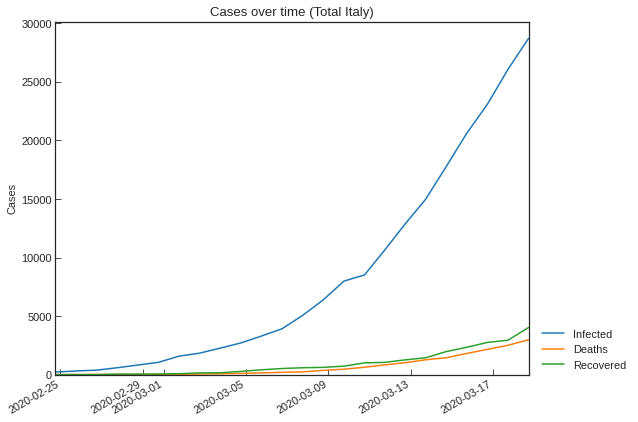

In [0]:
line_plot(total_df[data_cols], "Cases over time (Total Italy)", math_scale=False)

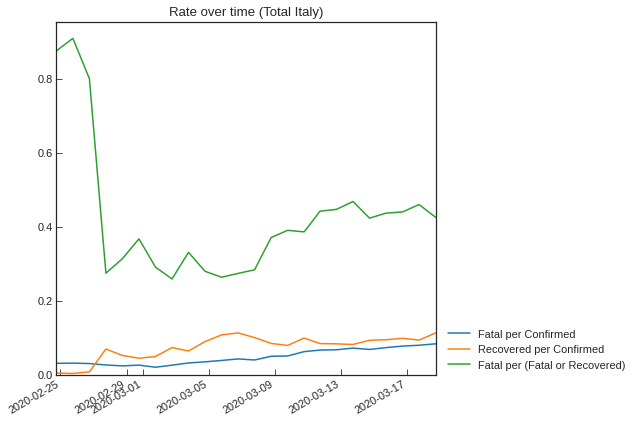

In [0]:
line_plot(total_df[rate_cols], "Rate over time (Total Italy)", ylabel="", math_scale=False)

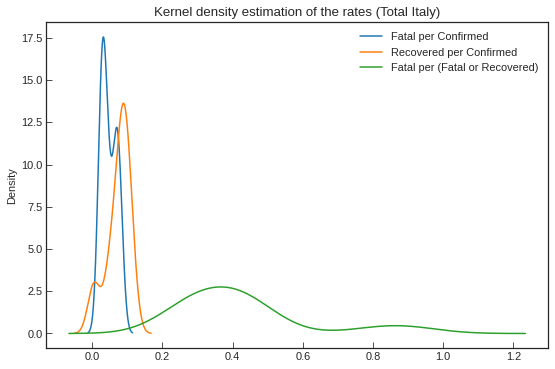

In [0]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates (Total Italy)")
plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


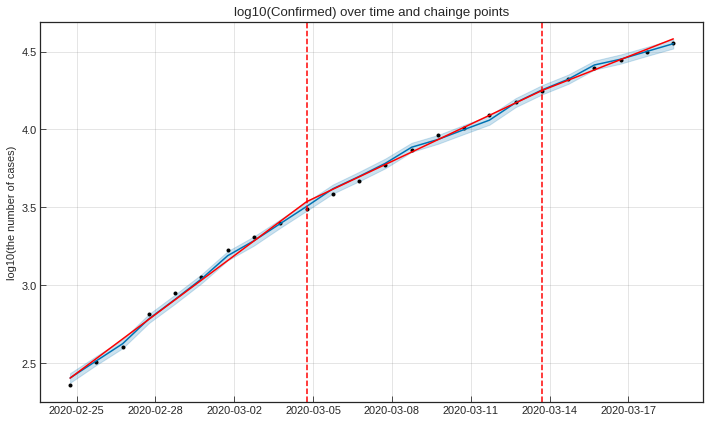

In [0]:
show_trend(ncov_df, variable="Confirmed", places=[("Italy", None)])

## Estimate parameters of SIR-F model

In [0]:
%%time
it_sirf_estimator = Estimator(
    SIRF, ncov_df, population_dict["Italy"], name="Italy", places=[("Italy", None)],
    start_date=it_start
)
it_sirf_dict = it_sirf_estimator.run()

CPU times: user 1min 44s, sys: 4.3 s, total: 1min 48s
Wall time: 1min 42s


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. U

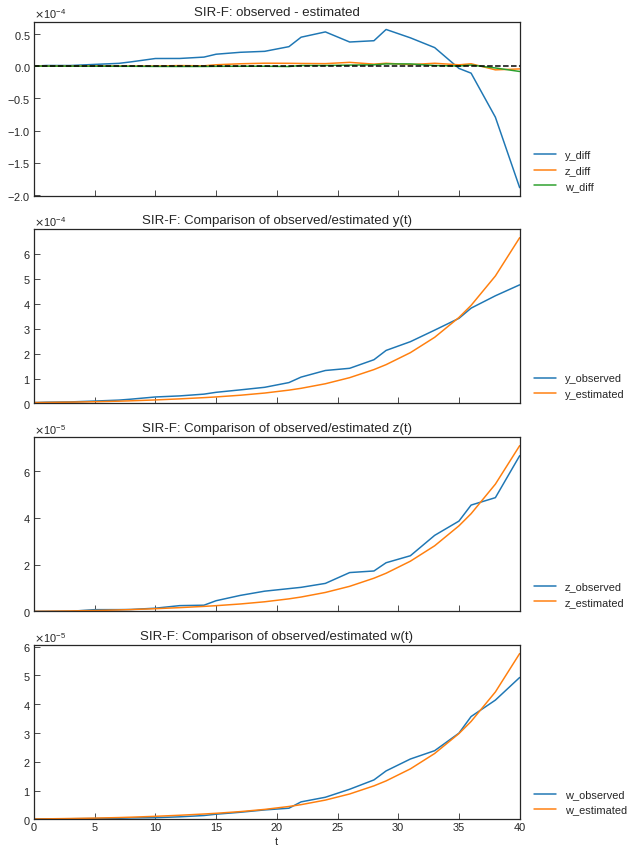

In [0]:
it_sirf_estimator.compare_graph()

## Estimate parameters of SEWIR-F model

In [0]:
_, info_dict, param_dict = it_sirf_estimator.info()
param_dict.pop("rho")
param_dict["tau"] = info_dict["tau"]
param_dict

{'kappa': 0.0006017546068062236,
 'sigma': 0.016606999045533512,
 'tau': 974,
 'theta': 0.07573041576606865}

In [0]:
%%time
it_estimator = Estimator(
    SEWIRF, ncov_df, population_dict["Italy"], name="Italy", places=[("Italy", None)],
    start_date=it_start,
    **param_dict
)
it_dict = it_estimator.run(700)

CPU times: user 1min 57s, sys: 3.4 s, total: 2min 1s
Wall time: 1min 55s


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. U

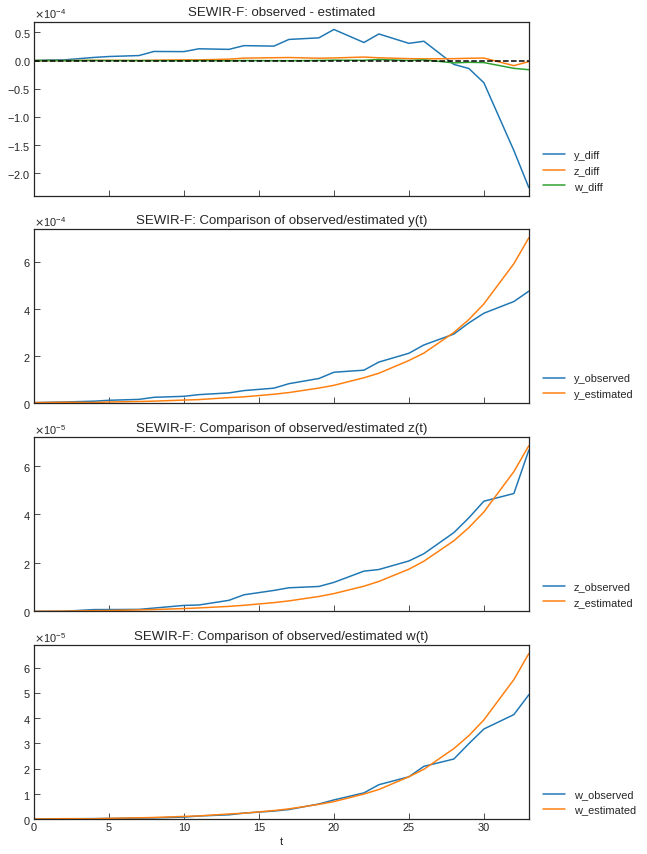

In [0]:
it_estimator.compare_graph()

In [0]:
pd.DataFrame.from_dict({"SIR-F": it_sirf_dict, "SEWIR-F": it_dict}, orient="index").fillna("-")

,tau,theta,kappa,rho,sigma,R0,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],rho1,rho2,rho3,1/beta1 [day],1/beta2 [day],1/beta3 [day]
SIR-F,974,0.07573,0.000602,0.189669,0.016607,10.19,0.000064,0.076,1124,3,40,-,-,-,-,-,-
SEWIR-F,974,0.07573,0.000602,-,0.016607,12.56,0.000187,0.076,1124,-,40,0.233825,0.898041,0.955995,2,0,0


## Prediction with SEWIR-F model (without lockdown)

In [0]:
first_model, info_dict, param_dict = it_estimator.info()
pd.DataFrame.from_dict({"No actions": param_dict}, orient="index")

,rho1,rho2,rho3,theta,kappa,sigma
No actions,0.233825,0.898041,0.955995,0.07573,0.000602,0.016607


### NOW

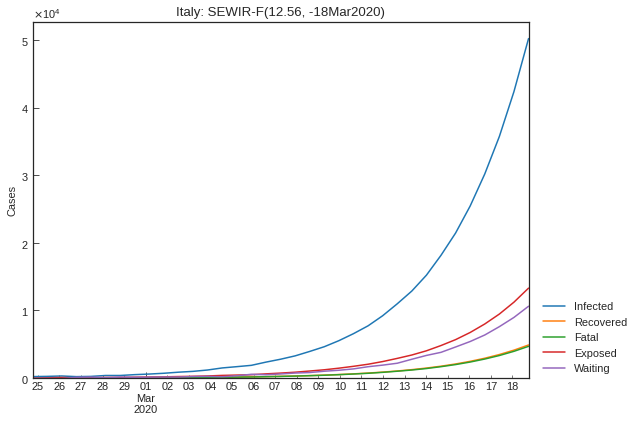

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=days_passed, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

In [0]:
df_without_lockdown_now = predicter.restore_df()
df_without_lockdown_now=df_without_lockdown_now.rename({"Fatal": "Deaths"}, axis=1)
df_without_lockdown_now=df_without_lockdown_now.loc[:datetime.today(), :]
df_without_lockdown_now.index.names = ['Date']
df_without_lockdown_now=df_without_lockdown_now.resample('D',convention='end').ffill()
total_df=total_df.resample('D',convention='end').ffill()


#df_without_lockdown_now.index = df_without_lockdown_now.index.floor('D')
#total_df.index = total_df.index.ceil('D')


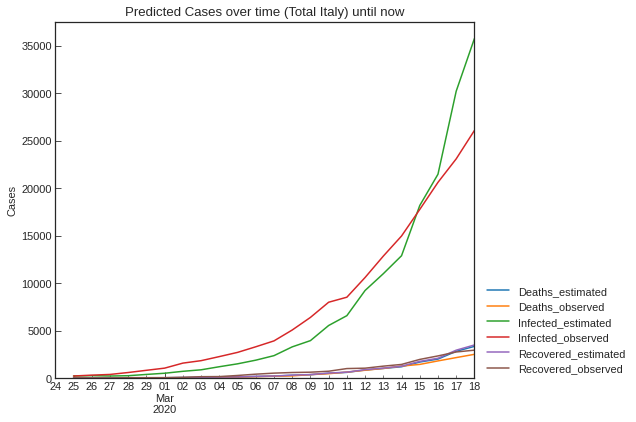

In [0]:
comp_df = pd.merge(total_df[data_cols], df_without_lockdown_now[data_cols], on="Date", suffixes=("_observed", "_estimated"))
comp_df = comp_df.reindex(sorted(comp_df.columns), axis=1)
line_plot(comp_df, "Predicted Cases over time (Total Italy) until now", math_scale=False)


In [0]:
comp_df

,Deaths_estimated,Deaths_observed,Infected_estimated,Infected_observed,Recovered_estimated,Recovered_observed
Date,,,,,,
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-25,7.0,7.0,221.0,221.0,1.0,1.0
2020-02-26,10.0,10.0,254.0,311.0,4.0,1.0
2020-02-27,8.0,12.0,218.0,385.0,13.0,3.0
2020-02-28,11.0,17.0,252.0,588.0,18.0,45.0
2020-02-29,24.0,21.0,386.0,821.0,30.0,46.0
2020-03-01,35.0,29.0,511.0,1049.0,37.0,50.0
2020-03-02,54.0,34.0,715.0,1577.0,57.0,83.0
2020-03-03,68.0,52.0,873.0,1835.0,70.0,149.0


### WITHIN 15 DAYS

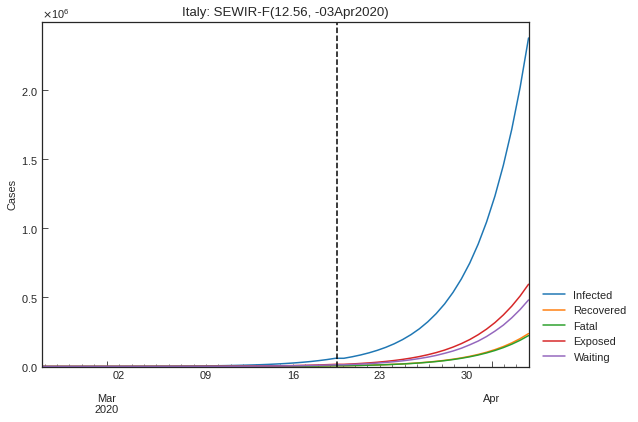

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(first_model, end_day_n=15, count_from_last=True, **param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

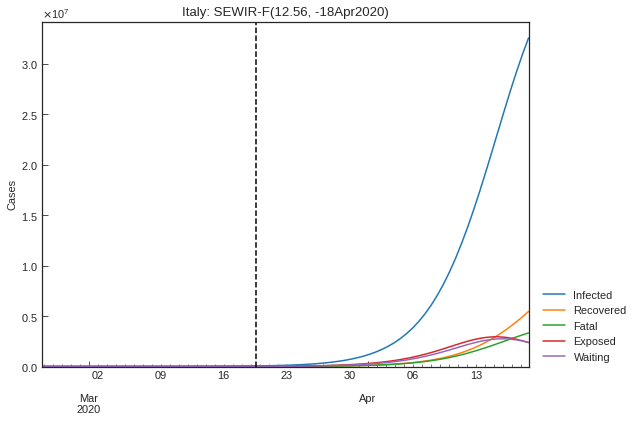

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(first_model, end_day_n=30, count_from_last=True, **param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

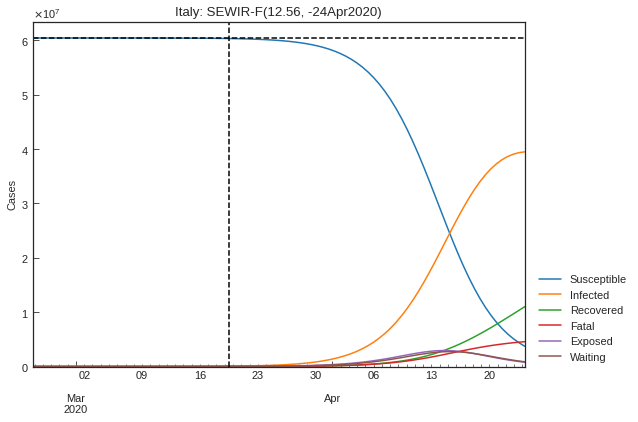

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=60, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None)

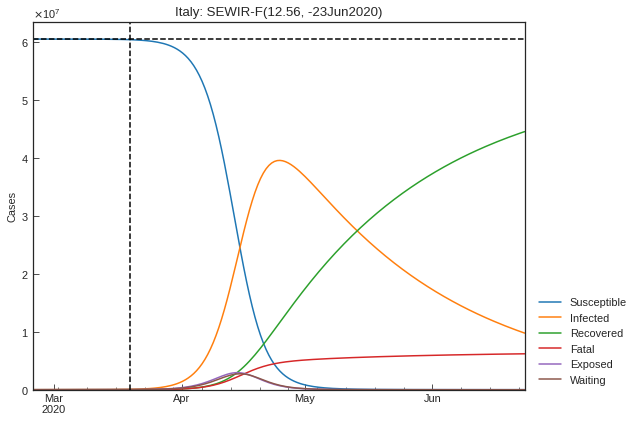

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=120, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None)

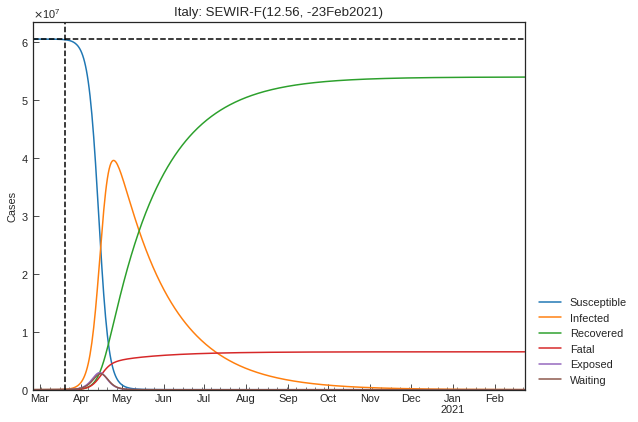

In [0]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=365, count_from_last=False, **param_dict)
predicter.restore_graph(drop_cols=None)

In [0]:
df_without_lockdown = predicter.restore_df()
df_without_lockdown= df_without_lockdown.loc[datetime.today()-timedelta(days=1):, :].head(30)
df_without_lockdown.index.names = ['Date']
df_without_lockdown=df_without_lockdown.resample('D',convention='end').ffill()
df_without_lockdown=df_without_lockdown.rename({"Fatal": "Deaths"}, axis=1)
df_without_lockdown=df_without_lockdown.loc[datetime.today():, :]
df_without_lockdown

,Susceptible,Infected,Recovered,Deaths,Exposed,Waiting
Date,,,,,,
2020-03-20,60362599.0,59454.0,5811.0,5564.0,15751.0,12645.0
2020-03-21,60322538.0,83620.0,8162.0,7829.0,22142.0,17533.0
2020-03-22,60296834.0,98846.0,9676.0,9260.0,26163.0,21045.0
2020-03-23,60230327.0,138909.0,13586.0,13016.0,36733.0,29254.0
2020-03-24,60187667.0,164380.0,16101.0,15407.0,43441.0,34827.0
2020-03-25,60077432.0,230695.0,22600.0,21628.0,60871.0,48597.0
2020-03-26,60006787.0,273061.0,26775.0,25605.0,71974.0,57621.0
2020-03-27,59824543.0,382774.0,37565.0,35902.0,100635.0,80406.0
2020-03-28,59707964.0,452786.0,44490.0,42477.0,118825.0,95281.0


## Effect of lockdown
Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).  
**Here, we will predict the effect of lockdown on 13Mar2020 with assumtion that the effect will be shown on a day in the near future.**

In [0]:
effect_day = datetime.strptime("29Mar2020", "%d%b%Y")

### How many days we have until the day the effect will be shown?

In [0]:
days = int((effect_day - datetime.today()).total_seconds() / 60 /60 /24)
days

9

## estimate average number people go out (before and after lockdown)

### How many days persons usually go out for each age group

In [0]:
# How many days persons usually go out for each age group
# Suggested by @marcoferrante, thank you for your kind cooperation!!
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
_out_df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)


In [0]:
# italy population pyramid
_age_bins = [
    "0-4", "5-9", "10-14", "15-19", "20-24", "25-29",
    "30-34", "35-39", "40-44", "45-49", "50-54", "55-59",
    "60-64", "65-69", "70-74", "75-79", "80-84", "85-89",
    "90-94", "95-99", "100+"
]
_male_values = [
    1197289,
    1374731, 
    1470174, 
    1484455, 
    1526577, 
    1625230, 
    1702976, 
    1824273, 
    2092329, 
    2401070, 
    2420466, 
    2274884, 
    1903045, 
    1679600, 
    1586760, 
    1182323, 
    958360, 
    504059, 
    186608, 
    39461,
    3055,
]
_female_values = [
    1127405,
    1295570,
    1387183,
    1391636,
    1415929,
    1535700,
    1662536,
    1808649,
    2096655,
    2431950,
    2487780,
    2384062,
    2050522,
    1851695,
    1805038,
    1454787,
    1344033,
    893202,
    453131,
    133178,
    13462,
]
df = pd.DataFrame(
    {
        "Age_bin": _age_bins,
        "Male": _male_values,
        "Female": _female_values,
    }
)
df[["Age_first", "Age_last"]] = df["Age_bin"].str.replace("+", "-122").str.split("-", expand=True).astype(int)
df["Total"] = df[["Male", "Female"]].sum(axis=1)
df["Mean"] = df["Total"] / (df["Age_last"] - df["Age_first"] + 1)
df = df.loc[:, ["Age_last", "Mean"]]
df.columns = ["Age", "Population"]
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df["Population"] = df["Population"].fillna(method="bfill").astype(np.int64)
pyramid_italy_df = df.copy()


In [0]:
df = pyramid_italy_df.copy()
# Population
df["Population"] = df["Population"].cumsum()
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], "Population"]
df["Population"] = df["Population"].diff().fillna(_first)
df["Portion"] = df["Population"] / df["Population"].sum()
# Detail of days
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
# Mannual adjustment
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
# Arrangement
out_italy_df = df.drop(["Age", "Types"], axis=1)
out_italy_df

,Age_first,Age_last,Period_of_life,Days,Population,Portion,School,Office,Others
0,0,2,nursery,3,1394814.0,0.023128,3,0,0
1,3,5,nursery school,5,1463936.0,0.024275,4,0,1
2,6,10,elementary school,6,2707711.0,0.044899,5,0,1
3,11,13,middle school,6,1714413.0,0.028428,5,0,1
4,14,18,high school,7,2872343.0,0.047629,6,0,1
5,19,25,university/work,7,4149909.0,0.068813,3,3,1
6,26,35,work,6,6620838.0,0.109785,0,6,0
7,36,45,work,5,8061920.0,0.133681,0,5,0
8,46,55,work,5,9706450.0,0.160950,0,5,0
9,56,65,work,5,8386980.0,0.139071,0,5,0


In [0]:
gs_before = (out_italy_df[["School", "Office", "Others"]].sum(axis=1) * out_italy_df["Portion"]).sum()
gs_before

5.013171154267619

### soft lockdown

In [0]:
df = out_italy_df.copy()
df["School"] = 0
df["Office"] = 0.5
df["Others"] = 0.3
df.loc[df.index[5:10], "Others"] = 1
out_italy_after_df = df.copy()
out_italy_after_df

,Age_first,Age_last,Period_of_life,Days,Population,Portion,School,Office,Others
0,0,2,nursery,3,1394814.0,0.023128,0,0.5,0.3
1,3,5,nursery school,5,1463936.0,0.024275,0,0.5,0.3
2,6,10,elementary school,6,2707711.0,0.044899,0,0.5,0.3
3,11,13,middle school,6,1714413.0,0.028428,0,0.5,0.3
4,14,18,high school,7,2872343.0,0.047629,0,0.5,0.3
5,19,25,university/work,7,4149909.0,0.068813,0,0.5,1.0
6,26,35,work,6,6620838.0,0.109785,0,0.5,1.0
7,36,45,work,5,8061920.0,0.133681,0,0.5,1.0
8,46,55,work,5,9706450.0,0.160950,0,0.5,1.0
9,56,65,work,5,8386980.0,0.139071,0,0.5,1.0


In [0]:
gs_after = (out_italy_after_df[["School", "Office", "Others"]].sum(axis=1) * out_italy_after_df["Portion"]).sum()
gs_after

1.2286102164275101

In [0]:
gs_after/gs_before*100

24.507645532541158

In [0]:
c_before, c_after = 1.0, 0.81

In [0]:
rho1_before = param_dict["rho1"]
rho1_after = rho1_before * (gs_after / gs_before) * (c_after / c_before)
(rho1_before, rho1_after)

(0.23382532511297277, 0.04641711629363944)

### Predict the future with the national lockdown

In [0]:
changed_param_dict = param_dict.copy()
changed_param_dict["rho1"] = rho1_after
df = pd.DataFrame.from_dict(
    {"No actions": param_dict, "With actions": changed_param_dict},
    orient="index"
)
df["R0"] = df.apply(lambda x: first_model(**x.to_dict()).calc_r0(), axis=1)
df["tau"] = info_dict["tau"]
df

,rho1,rho2,rho3,theta,kappa,sigma,R0,tau
No actions,0.233825,0.898041,0.955995,0.07573,0.000602,0.016607,12.56,974
With actions,0.046417,0.898041,0.955995,0.07573,0.000602,0.016607,2.49,974


### IN A WEEK

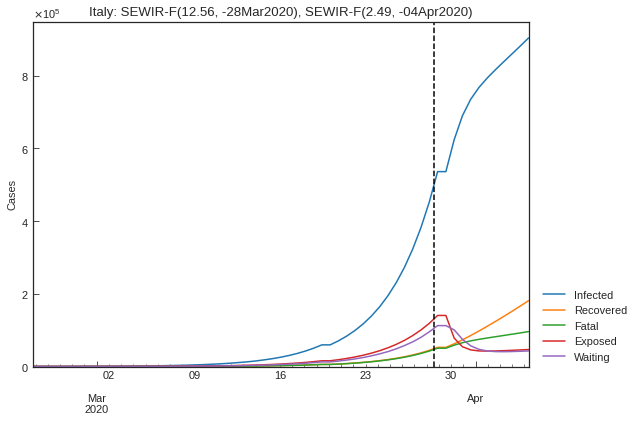

In [0]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=days, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=7, count_from_last=True, **changed_param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

In [0]:
df_with_lockdown = predicter.restore_df()
df_with_lockdown= df_with_lockdown.loc[datetime.today()-timedelta(days=1):, :].head(30)
df_with_lockdown.index.names = ['Date']
df_with_lockdown=df_with_lockdown.resample('D',convention='end').ffill()
df_with_lockdown=df_with_lockdown.rename({"Fatal": "Deaths"}, axis=1)
df_with_lockdown=df_with_lockdown.loc[datetime.today():, :]
df_with_lockdown

,Susceptible,Infected,Recovered,Deaths,Exposed,Waiting
Date,,,,,,
2020-03-20,60362597.0,59474.0,5811.0,5565.0,15756.0,12620.0
2020-03-21,60344260.0,70494.0,6887.0,6599.0,18671.0,14912.0
2020-03-22,60322544.0,83523.0,8163.0,7821.0,22115.0,17657.0
2020-03-23,60266375.0,117262.0,11465.0,10985.0,31028.0,24708.0
2020-03-24,60230333.0,138838.0,13587.0,13010.0,36712.0,29343.0
2020-03-25,60137163.0,194870.0,19075.0,18266.0,51465.0,40986.0
2020-03-26,60077431.0,230697.0,22600.0,21628.0,60872.0,48594.0
2020-03-27,59923243.0,323492.0,31714.0,30336.0,85175.0,67864.0
2020-03-28,59824539.0,382817.0,37564.0,35905.0,100648.0,80351.0


### WITHIN A MONTH

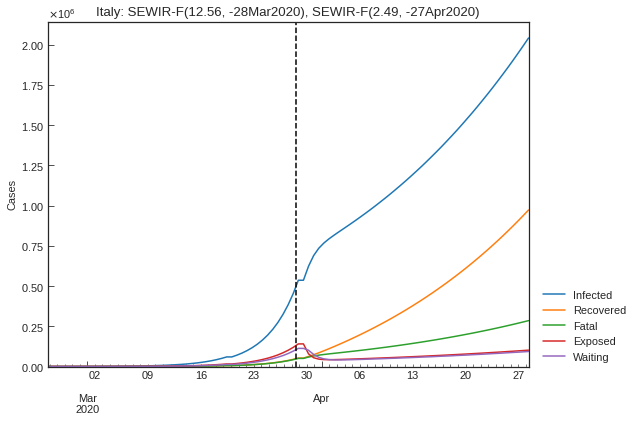

In [0]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=days, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=30, count_from_last=True, **changed_param_dict)
predicter.restore_graph(drop_cols=["Susceptible"])

### WITHIN an YEAR

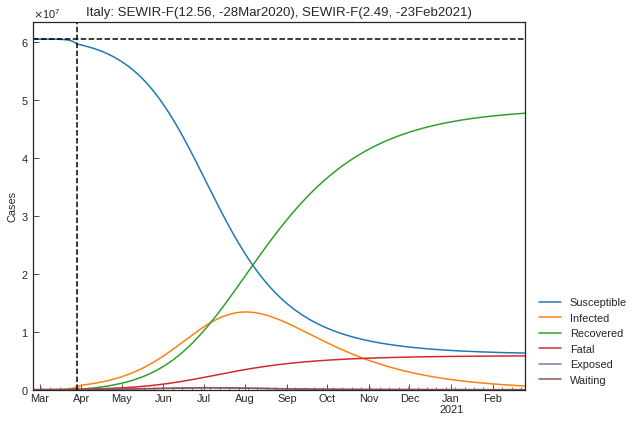

In [0]:
predicter = Predicter(**info_dict)
predicter.add(SEWIRF, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(SEWIRF, end_day_n=days, count_from_last=True, **param_dict)
predicter.add(SEWIRF, end_day_n=365, count_from_last=False, **changed_param_dict)
predicter.restore_graph(drop_cols=None)

# Comparison of scenario with and without lockdown

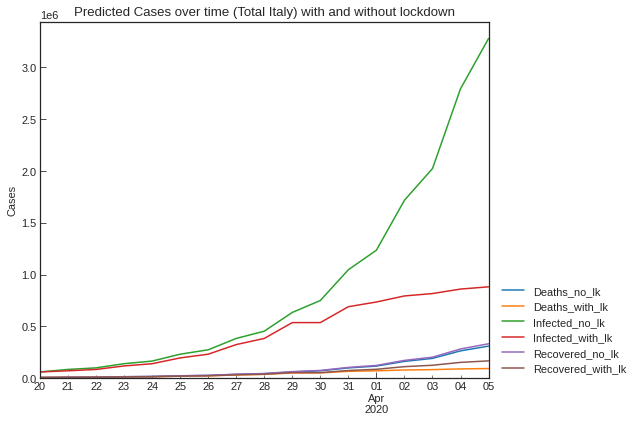

In [0]:
comp_df = pd.merge(df_with_lockdown[data_cols], df_without_lockdown[data_cols], on="Date", suffixes=("_with_lk", "_no_lk"))
comp_df = comp_df.reindex(sorted(comp_df.columns), axis=1)
line_plot(comp_df, "Predicted Cases over time (Total Italy) with and without lockdown", math_scale=False)

In [0]:
comp_df

,Deaths_no_lk,Deaths_with_lk,Infected_no_lk,Infected_with_lk,Recovered_no_lk,Recovered_with_lk
Date,,,,,,
2020-03-20,5564.0,5565.0,59454.0,59474.0,5811.0,5811.0
2020-03-21,7829.0,6599.0,83620.0,70494.0,8162.0,6887.0
2020-03-22,9260.0,7821.0,98846.0,83523.0,9676.0,8163.0
2020-03-23,13016.0,10985.0,138909.0,117262.0,13586.0,11465.0
2020-03-24,15407.0,13010.0,164380.0,138838.0,16101.0,13587.0
2020-03-25,21628.0,18266.0,230695.0,194870.0,22600.0,19075.0
2020-03-26,25605.0,21628.0,273061.0,230697.0,26775.0,22600.0
2020-03-27,35902.0,30336.0,382774.0,323492.0,37565.0,31714.0
2020-03-28,42477.0,35905.0,452786.0,382817.0,44490.0,37564.0
